# Model s augmentacijom podataka

## Početno postavljanje

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip cats_vs_dogs_baseline_dataset.zip

In [ ]:
import albumentations as A

augmentations = A.Compose([

    # Geometrijske transformacije
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.4),Ge
    A.RandomResizedCrop(height=180, width=180, scale=(0.8, 1.0), p=0.5),

    # Fotometrijske transformacije
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2)

])


In [ ]:
from matplotlib import pyplot as plt

# Funkcija za prikaz metrika povijesti treniranja
def plot_all_metrics(history):
    epochs = range(1, len(history['accuracy']) + 1)

    metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    metric_titles = {
        'accuracy': 'Točnost',
        'precision': 'Preciznost',
        'recall': 'Osjetljivost',
        'auc': 'AUC',
        'loss': 'Gubitak'
    }

    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))

        # Graf trening metrika
        plt.plot(epochs, history[metric], 'bo', label=f'Trening {metric_titles[metric]}')

        # Graf validacijskih metrika
        val_metric = f'val_{metric}'
        plt.plot(epochs, history[val_metric], 'b', label=f'Validacija {metric_titles[metric]}')

        plt.title(f'Trening i validacija - {metric_titles[metric]}')
        plt.xlabel('Epoha')
        plt.ylabel(metric_titles[metric])
        plt.legend()

        plt.show()

## Definiranje arhitekture modela

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Konvolucijska baza
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
# Gusti slojevi
x = layers.Dense(512, activation="relu")(x)

# Završni sloj za  binarnu klasifikaciju
outputs = layers.Dense(1, activation="sigmoid")(x)

# Kreiranje modela
model = keras.Model(inputs=inputs, outputs=outputs)

## Kompajliranje modela

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np

# Omatajuća klasa
class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        self.augment = augment

    def __len__(self):
        return len(self.datagen)

    def __getitem__(self, index):
        images, labels = self.datagen[index]
        augmented_images = np.array([self.augment(image=image)['image'] for image in images])
        return augmented_images, labels

    def __iter__(self):
        return iter(self.datagen)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Kreiranje instance ImageDataGeneratora
image_data_gen = ImageDataGenerator()

# Omatanje IDG u ADG
augmented_data = AugmentDataGenerator(
    image_data_gen.flow_from_directory(
        '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/train',
        target_size=(180, 180),
        batch_size=32,
        class_mode='binary'
    ),
    augment=augmentations
)

validation_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/validation',
    label_mode='binary',
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/test',
    label_mode='binary',
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Treniranje modela

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/augmentation_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    augmented_data,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 [==============================] - 6s 90ms/step - loss: 0.3911 - accuracy: 0.8265 - precision: 0.8408 - recall: 0.9279 - auc: 0.8743 - val_loss: 0.4375 - val_accuracy: 0.8200 - val_precision: 0.8412 - val_recall: 0.9157 - val_auc: 0.8604
Epoch 2/100
63/63 [==============================] - 5s 78ms/step - loss: 0.3776 - accuracy: 0.8275 - precision: 0.8366 - recall: 0.9364 - auc: 0.8817 - val_loss: 0.4249 - val_accuracy: 0.8290 - val_precision: 0.8795 - val_recall: 0.8757 - val_auc: 0.8722
Epoch 3/100
63/63 [==============================] - 4s 70ms/step - loss: 0.3824 - accuracy: 0.8290 - precision: 0.8382 - recall: 0.9364 - auc: 0.8777 - val_loss: 0.4282 - val_accuracy: 0.8140 - val_precision: 0.8813 - val_recall: 0.8486 - val_auc: 0.8687
Epoch 4/100
63/63 [==============================] - 5s 72ms/step - loss: 0.3894 - accuracy: 0.8125 - precision: 0.8233 - recall: 0.9321 - auc: 0.8720 - val_loss: 0.4553 - val_accuracy: 0.8280 - val_precision: 0.8333 - val_recall: 0

## Rezultati i najbolji model

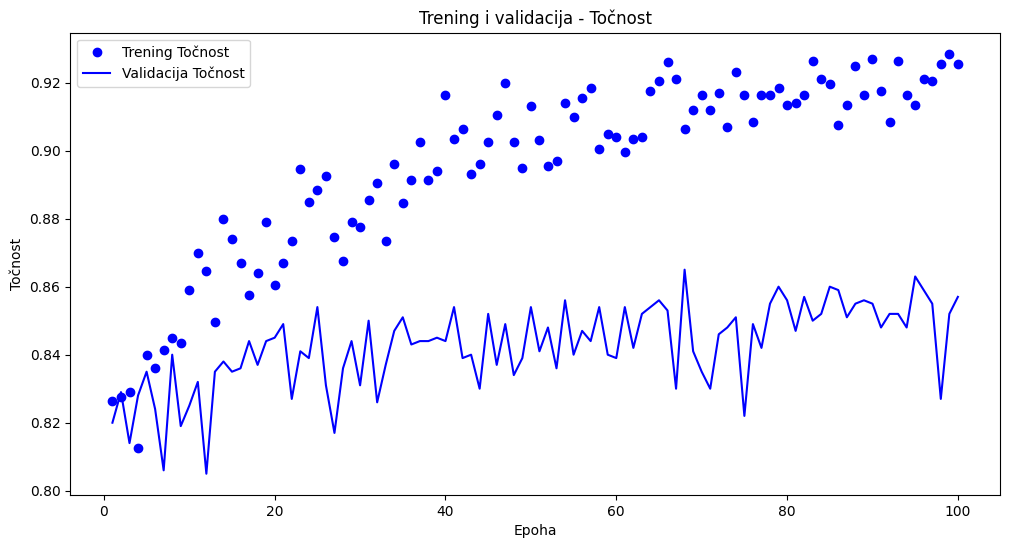

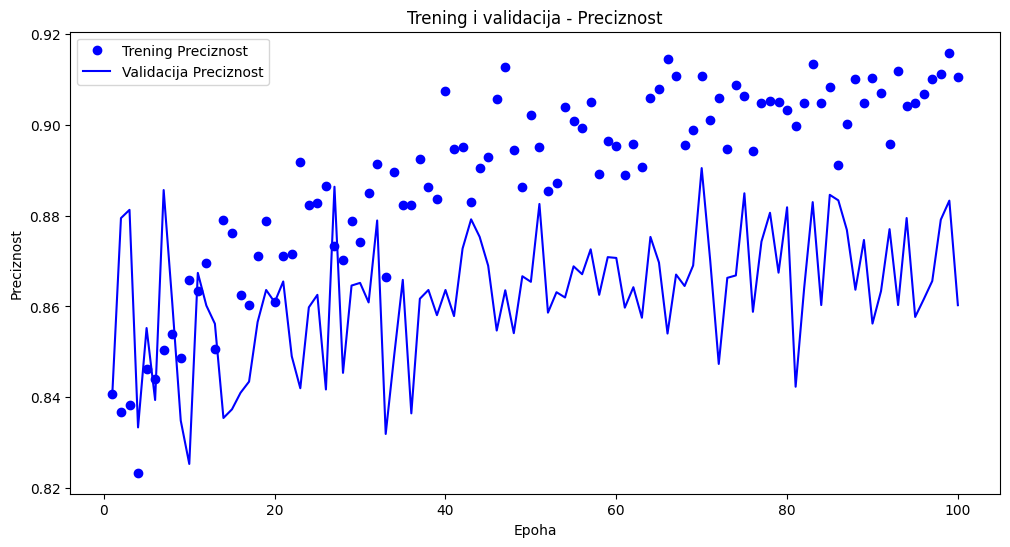

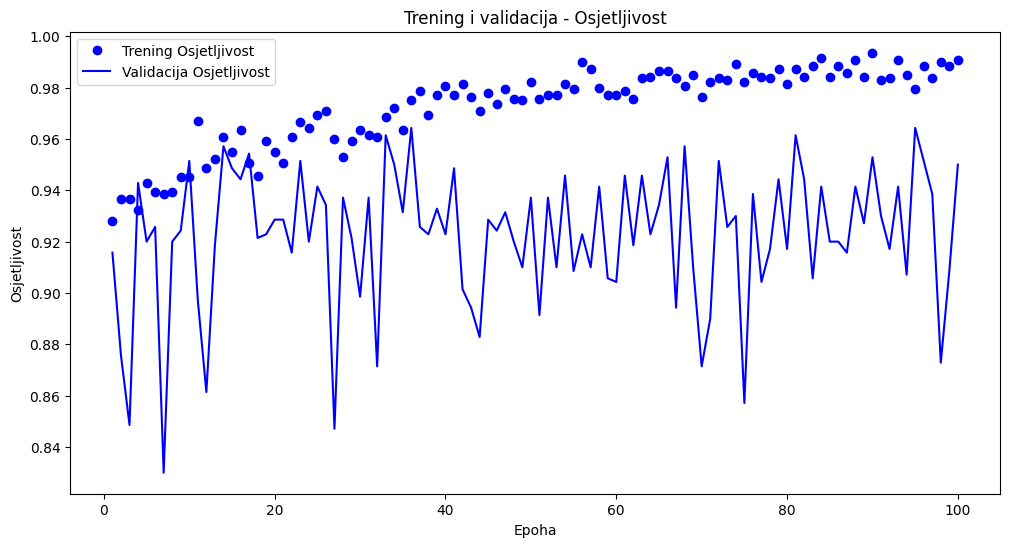

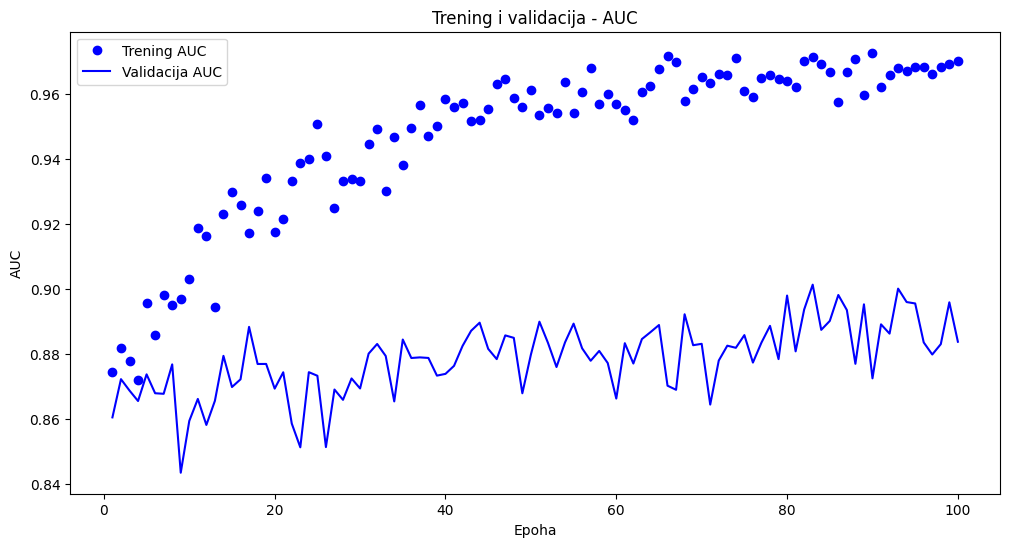

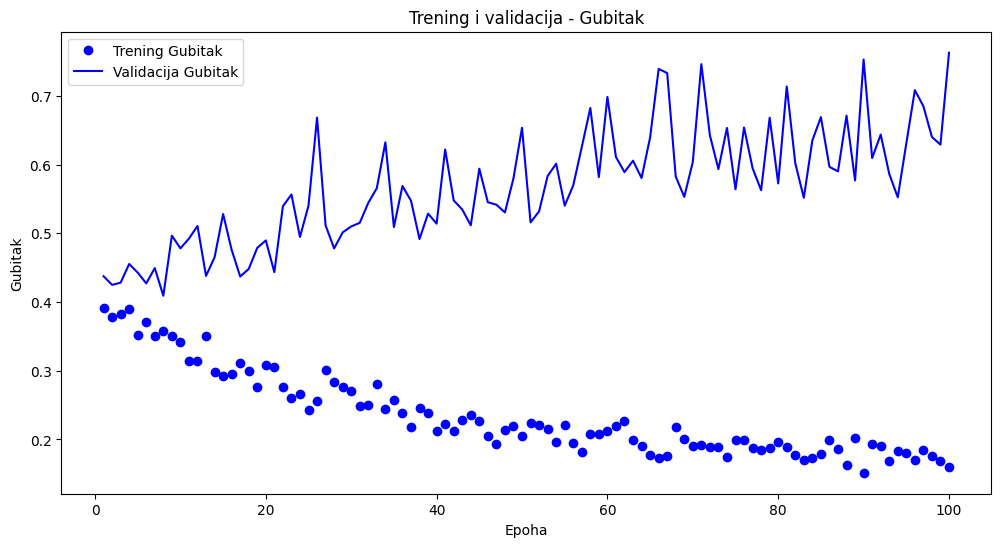

In [ ]:
# Prikaz svih praćenih metrika
plot_all_metrics(history.history)


In [ ]:
from tensorflow.keras import metrics

# Učitavanje najboljeg modela (po gubitku)
test_model = keras.models.load_model("/content/drive/MyDrive/augmentation_model.keras")

# Evaluacija najboljeg modela nad testnim podatkovnim setom
test_metrics = test_model.evaluate(test_dataset)

# test_metrics u prvom elementu ima spremljen gubitak,
# ostali elementi su metrike redom pojavljivanja kao i kod kompajliranja modela
print(f"Test gubitak: {test_metrics[0]:.3f}")
print(f"Test točnost: {test_metrics[1]:.3f}")
print(f"Test preciznost: {test_metrics[2]:.3f}")
print(f"Test osjetljivost: {test_metrics[3]:.3f}")
print(f"Test AUC: {test_metrics[4]:.3f}")


63/63 [==============================] - 77s 1s/step - loss: 0.3859 - accuracy: 0.8360 - precision: 0.8569 - recall: 0.9193 - auc: 0.8913
Test gubitak: 0.386
Test točnost: 0.836
Test preciznost: 0.857
Test osjetljivost: 0.919
Test AUC: 0.891


In [ ]:
import numpy as np

# Ekstrakcija istinitih vrijednosti i predviđenih vjerojatnosti iz testnog seta
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = test_model.predict(test_dataset)

63/63 [==============================] - 1s 19ms/step


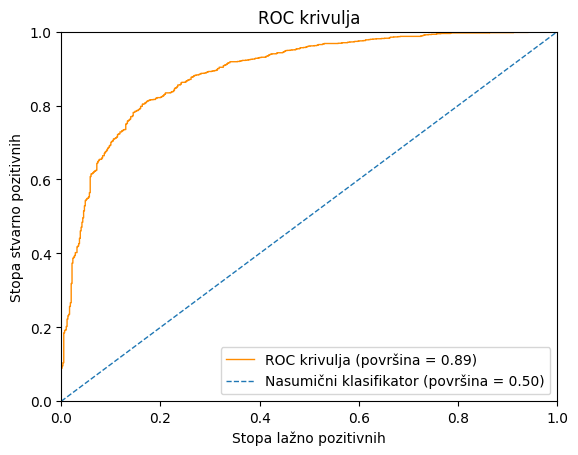

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC krivulja i AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Vrijednosti nasumičnog klasifikatora (50%)
fpr_random = [0, 1]
tpr_random = [0, 1]

# Crtanje ROC krivulje
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC krivulja (površina = %0.2f)' % roc_auc)
plt.plot(fpr_random, tpr_random, linestyle='--', lw=1, label='Nasumični klasifikator (površina = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Stopa lažno pozitivnih')
plt.ylabel('Stopa stvarno pozitivnih')
plt.title('ROC krivulja')
plt.legend(loc="lower right")
plt.show()

### Performanse modela nad manje zastupljenom klasom

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Konverzija predviđenih vjerojatnosti u dvije klase
y_pred_labels = (y_pred > 0.5).astype("int32")

# Detaljizirano klasifikacijsko izvješće
print(classification_report(y_true, y_pred_labels, target_names=['mačka', 'pas']))

# Metrike za klasu mačka.
precision = precision_score(y_true, y_pred_labels, pos_label=0)
recall = recall_score(y_true, y_pred_labels, pos_label=0)
f1 = f1_score(y_true, y_pred_labels, pos_label=0)

print(f'Preciznost za klasu mačka: {precision:.3f}')
print(f'Osjetljivost za klasu mačka: {recall:.3f}')
print(f'F1 metrika za klasu mačka: {f1:.3f}')


              precision    recall  f1-score   support

       mačka       0.77      0.64      0.70       600
         pas       0.86      0.92      0.89      1400

    accuracy                           0.84      2000
   macro avg       0.81      0.78      0.79      2000
weighted avg       0.83      0.84      0.83      2000

Preciznost za klasu mačka: 0.773
Osjetljivost za klasu mačka: 0.642
F1 metrika za klasu mačka: 0.701


## Uzorkovanje augmentiranih fotografija

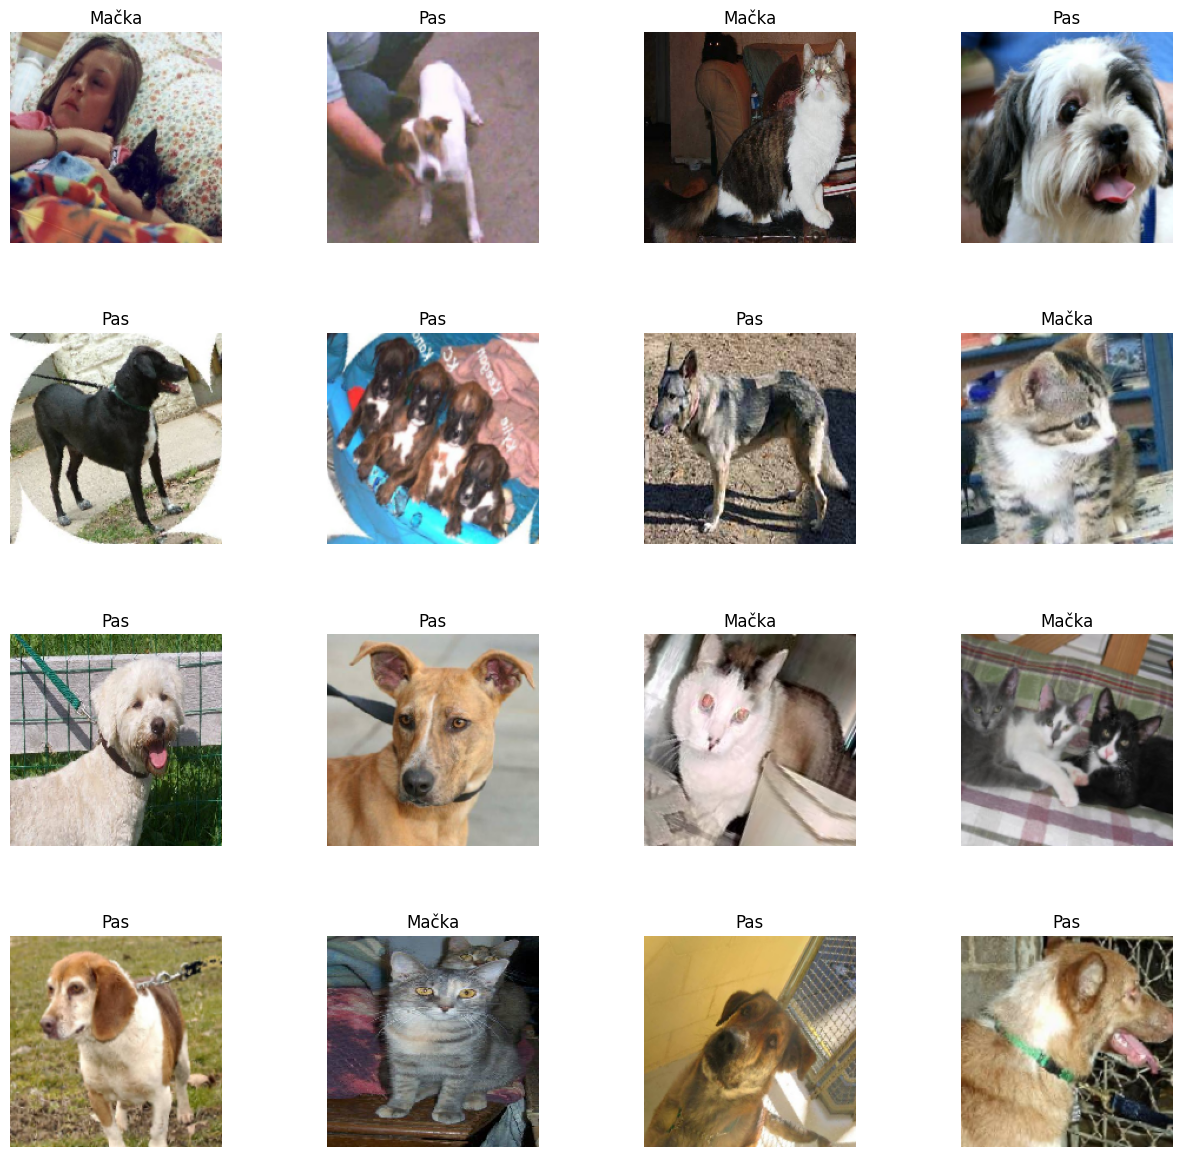

In [ ]:
import numpy as np

def get_batch_from_augmented_data(augmented_data_gen):
    batch_x, batch_y = next(iter(augmented_data_gen.datagen))
    augmented_batch_x = []
    for image in batch_x:
        augmented_image = augmented_data_gen.augment(image=image)["image"]
        augmented_batch_x.append(augmented_image)
    return np.array(augmented_batch_x), batch_y

# Dohvaćanje batcha
augmented_batch_x, labels_batch = get_batch_from_augmented_data(augmented_data)

# Zadrzavanje samo prvih 16 fotografija
augmented_images = augmented_batch_x[:16]
labels = labels_batch[:16]

# Ispis labela
labels = ["Pas" if label == 1 else "Mačka" for label in labels]

# Plot the images
plot_images(augmented_images, labels, 4, 4)

